<a href="https://colab.research.google.com/github/LennonLab/sporeAI/blob/dylan/CellSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellSAM segmentation

Make sure to change runtime type to GPU for ML applications <br>
- Runtime -> Change runtime type -> T4 GPU



### Getting Started

In [1]:
# have to run the below command for every new colab session
# !pip install git+https://github.com/vanvalenlab/cellSAM.git

In [2]:
from cellSAM import segment_cellular_image, get_model
import numpy as np
import torch
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.patches as patches
import cv2


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)


In [3]:
def sidebyside(img1, img2, title1='', title2=''):
  fig, axes = plt.subplots(1,2, figsize=(16,16))

  # image 1
  axes[0].imshow(img1)
  axes[0].set_title(title1)

  # image 2
  axes[1].imshow(img2)
  axes[1].set_title(title2)

  plt.show()




**cellSAM on test image from cellSAM people**

In [4]:
# download test image from cellSAM files
!curl -O https://storage.googleapis.com/cellsam-data/yeaz.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3072k  100 3072k    0     0  5403k      0 --:--:-- --:--:-- --:--:-- 5408k


In [5]:
img = np.load('yeaz.npy')
print(img.shape)


(512, 512, 3)


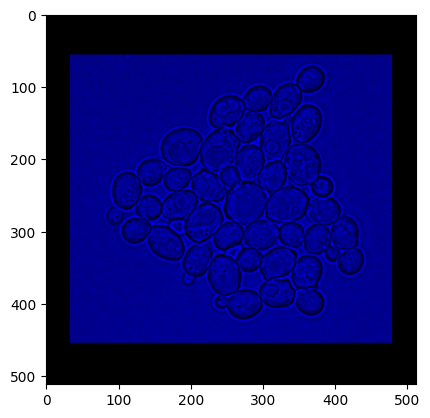

In [6]:
plt.imshow(img)
plt.show()

In [7]:
# Run segmentation of img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))

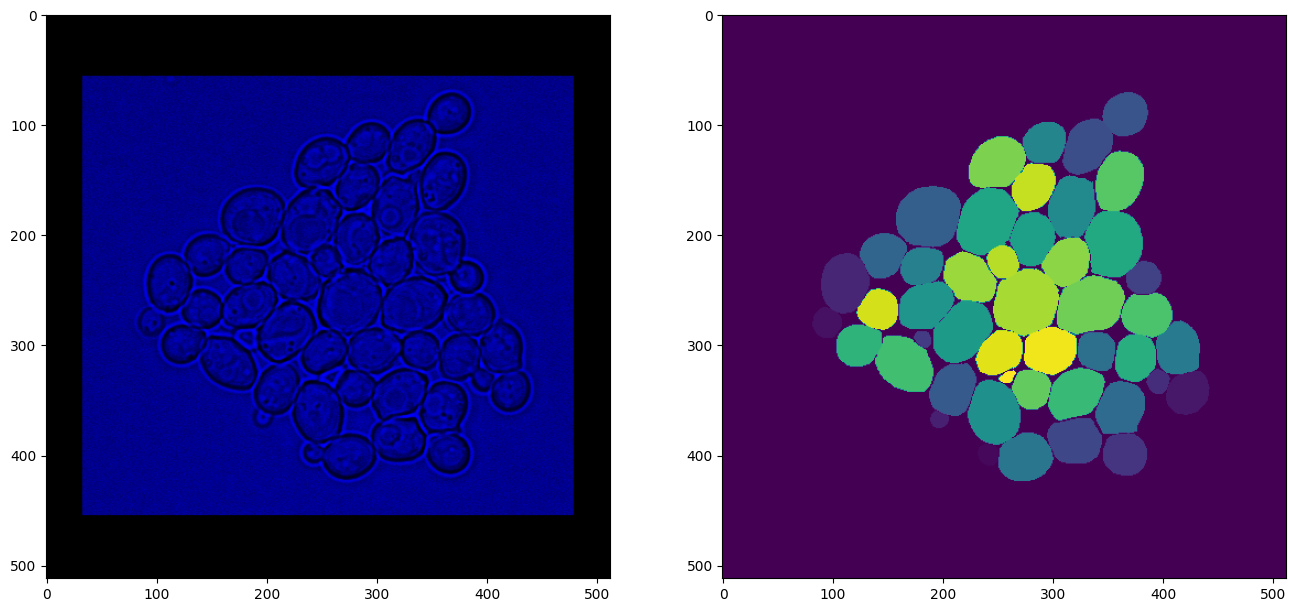

In [8]:
sidebyside(img, mask)

****
**cellSAM on our microscopy images**

In [35]:
imgpath = "20240917_delta6_100x_1.tif"
img = io.imread(imgpath)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
print(img.shape)

(804, 804, 3)


In [31]:
import scipy.ndimage as ndi

sigma = 1
img = ndi.filters.gaussian_filter(img, sigma)


<ipython-input-31-cfb78ac82a5a>:4: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  img = ndi.filters.gaussian_filter(img, sigma)


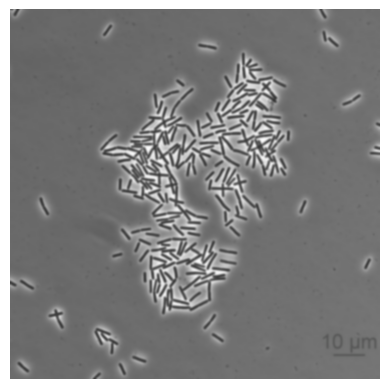

In [26]:
plt.imshow(img)
plt.axis('off')
plt.show()

**Preprocessing**

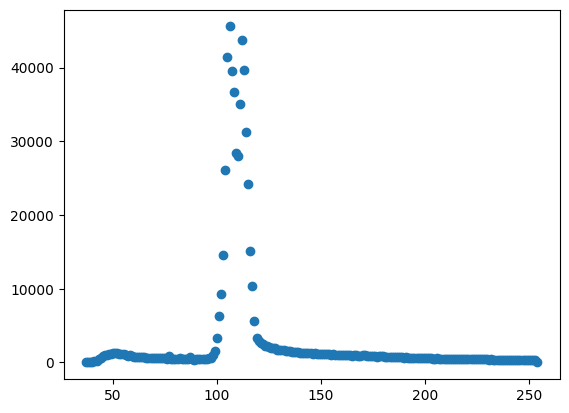

In [12]:
# histogram used to view the distribution of pixel intensities
from skimage.exposure import histogram

(counts, bins) = histogram(img[:,:,0])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(bins, counts)

In [13]:
def HistandCDF(img1, img2, cdf=True):
  # compute histograms
  counts_1, bins_1 = histogram(img1)
  counts_2, bins_2 = histogram(img2)

  # compute cumulative distribution functions
  img_cdf_1, bins_1 = exposure.cumulative_distribution(img1, 256)
  img_cdf_1 = img_cdf_1
  img_cdf_2, bins_2 = exposure.cumulative_distribution(img2)
  img_cdf_2 = img_cdf_2

  # view images and histograms
  if cdf:
    fig, axes = plt.subplots(2,2, figsize=(10,10))
  else:
    fig, axes = plt.subplots(1,2, figsize=(10,10))

  if cdf:
    ## original image
    axes[0,0].imshow(img1, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[0, 0].axis('off')

    ## 2 image
    axes[0,1].imshow(img2, cmap='gray')
    axes[0,1].set_title('Processed Image')
    axes[0, 1].axis('off')


    ## original histogram and cdf
    right_y_axis_0 = axes[1,0].twinx()
    axes[1,0].scatter(bins_1, counts_1, label='Original', color='blue')
    # right_y_axis_0.set_ylim(0,1)
    right_y_axis_0.plot(bins_1, img_cdf_1, color='red')
    axes[1, 0].axis('off')

    ## 2 histogram and cdf
    right_y_axis_1 = axes[1,1].twinx()
    axes[1,1].scatter(bins_2, counts_2, label='Processed', color='blue')
    # right_y_axis_1.set_ylim(0,1)
    right_y_axis_1.plot(bins_2, img_cdf_2, color='red')
    axes[1, 1].axis('off')

  else:
      ## original image
      axes[0].imshow(img1, cmap='gray')
      axes[0].set_title('Original Image')
      axes[0].axis('off')

      ## 2 image
      axes[1].imshow(img2, cmap='gray')
      axes[1].set_title('Processed Image')
      axes[1].axis('off')

  plt.show()

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


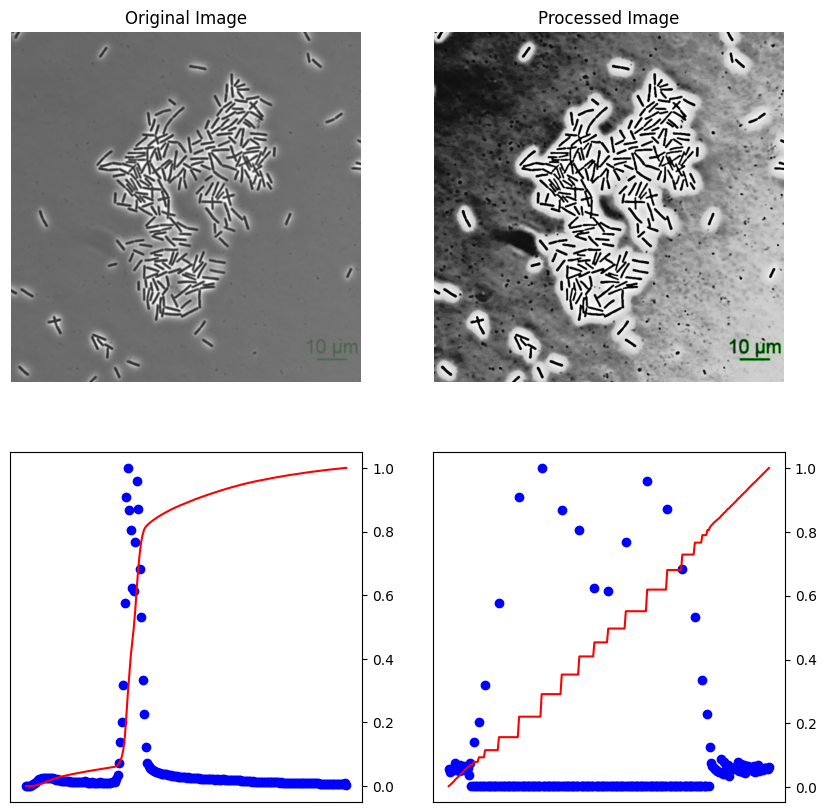

In [14]:
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity, adjust_gamma
from skimage import exposure

img_copy = img
img_eq = equalize_hist(img_copy)

HistandCDF(img_copy, img_eq,)




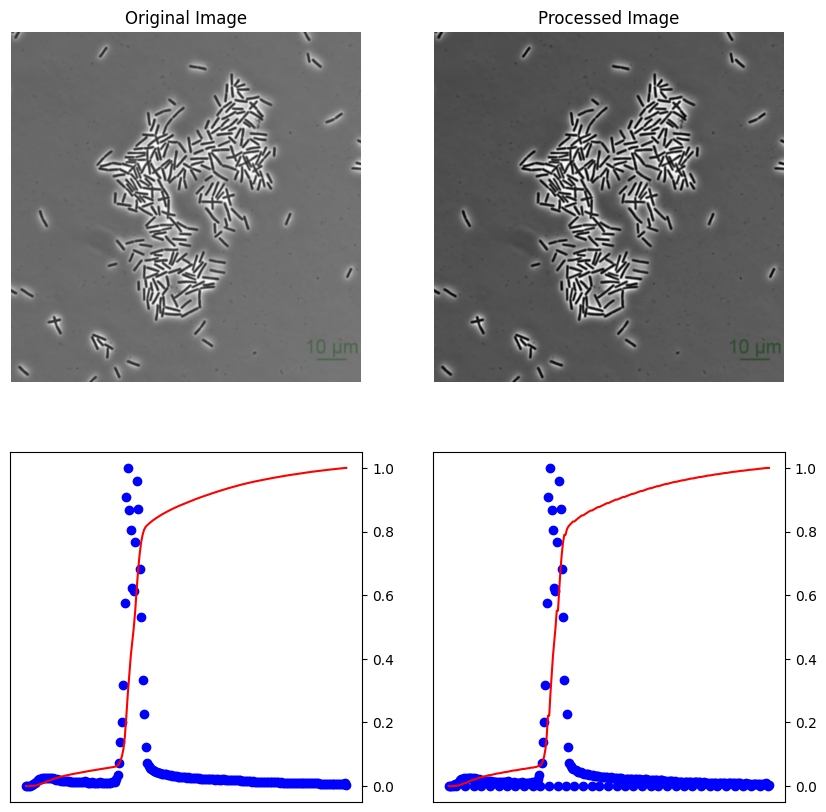

In [15]:
img_copy = img
img_rescale = rescale_intensity(img_copy)

HistandCDF(img_copy, img_rescale)

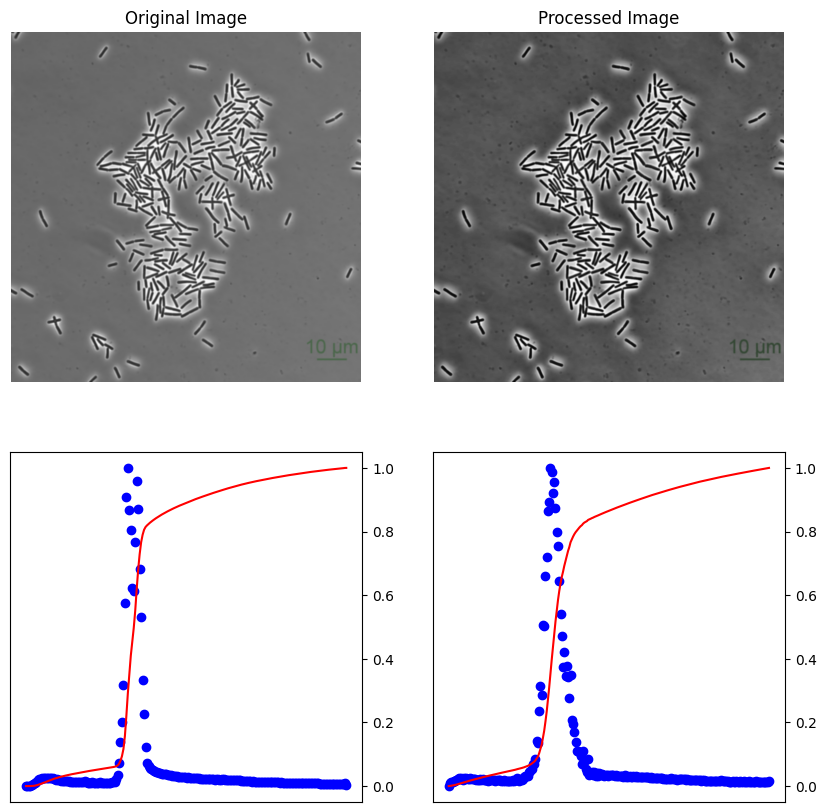

In [16]:
img_copy = img
img_eqadapt = equalize_adapthist(img_copy)

HistandCDF(img_copy, img_eqadapt)

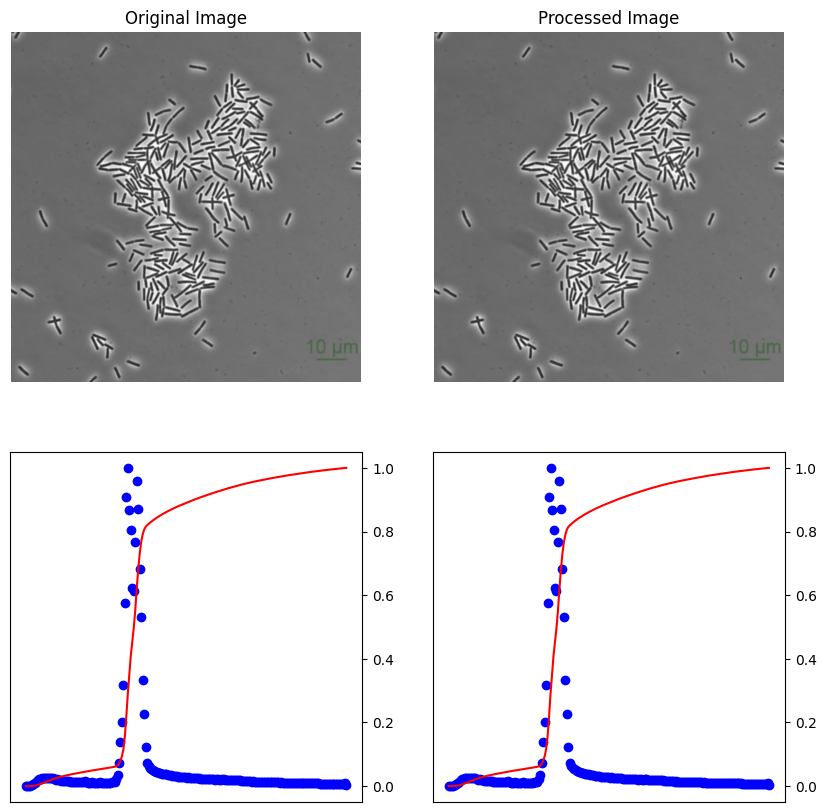

In [17]:
img_copy = img
img_gamma = adjust_gamma(img_copy, gamma=1, gain=1)

HistandCDF(img_copy, img_gamma)

In [66]:
img_all = adjust_gamma(img_copy, gamma=1, gain=1)
img_all = equalize_adapthist(img_all)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


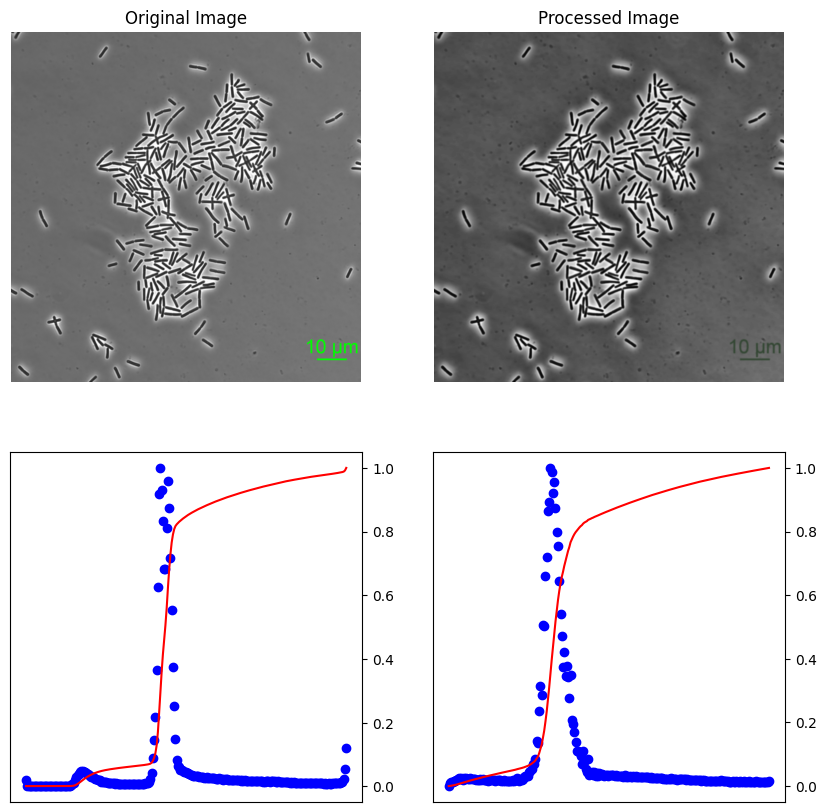

In [67]:
HistandCDF(img, img_all)

/usr/local/lib/python3.10/dist-packages/cellSAM/sam_inference.py:272: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")


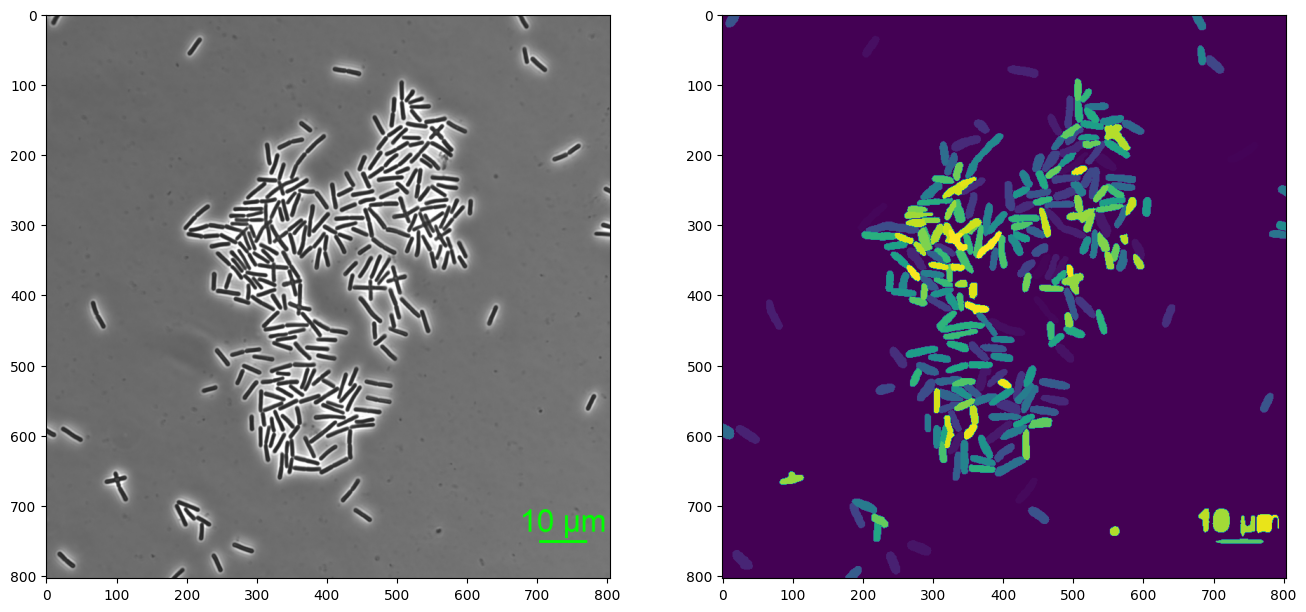

In [69]:
# Run segmentation of img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask, embedding, bounding_boxes = segment_cellular_image(img_gamma, device=str(device))
sidebyside(img, mask)

**Cell Counts**

In [73]:
values, counts = np.unique(mask, return_counts=True)
cells = dict(zip(values, counts))
print(len(values))

270


In [83]:
counts[0:10]

array([567724,    495,    427,    425,    426,    307,    353,    423,
          339,    449])

In [74]:
np.average(counts[1:])

292.5353159851301

In [75]:
np.min(counts)

48

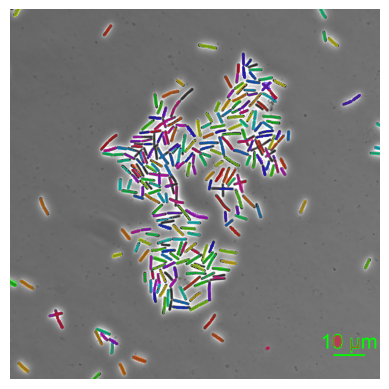

In [76]:
colored_mask = np.ma.masked_where(mask==0, mask)
plt.imshow(img)

#overlay the mask with a color map and transparency
plt.imshow(colored_mask, cmap='hsv', alpha=0.5)
plt.axis('off')
plt.show()

**using CV**

In [36]:
img_blurred = cv2.GaussianBlur(img, (5,5), 0)


In [23]:
#!pip install ipywidgets

In [38]:
from ipywidgets import interact

%matplotlib inline

@interact(thres=(0,255,1))
def threshold_image(thres):
  img_thres = img_blurred > thres
  img_thres = np.where(img_thres, 255, 0).astype(np.uint8)

  plt.figure(figsize=(5,5))
  plt.imshow(img_thres, interpolation='none')
  plt.show()

interactive(children=(IntSlider(value=127, description='thres', max=255), Output()), _dom_classes=('widget-int…

In [40]:
thres = 93

_, img_thres = cv2.threshold(img_blurred, thres, 255, cv2.THRESH_BINARY)

In [42]:
img_thres.shape

(804, 804, 3)

/usr/local/lib/python3.10/dist-packages/cellSAM/sam_inference.py:272: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")


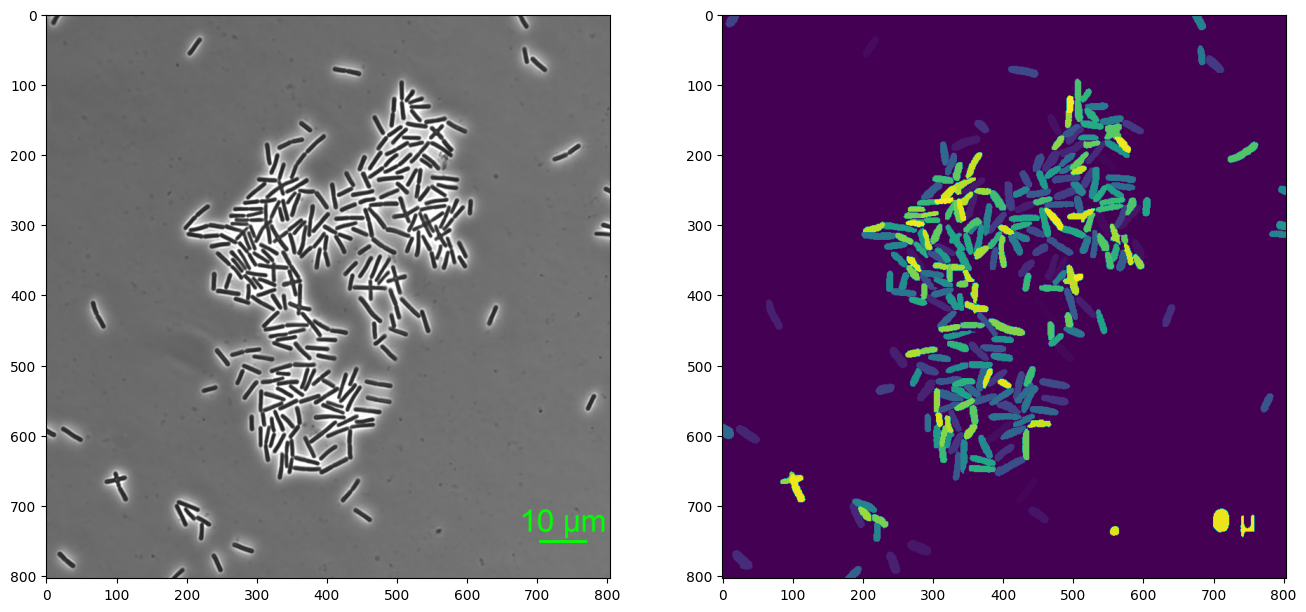

In [72]:
# Run segmentation of img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))
sidebyside(img, mask)

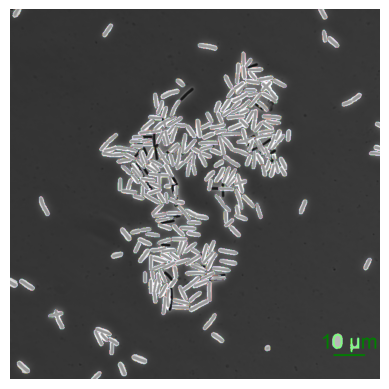

In [62]:
# colored_mask = np.ma.masked_where(mask==0, mask)
binary_mask = mask > 0
plt.imshow(img)

#overlay the mask with a color map and transparency
plt.imshow(binary_mask, cmap='cubehelix', alpha=.5)
plt.axis('off')
plt.show()

In [84]:
def RunImage(img, filename):
  # Run segmentation of img
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))

  # Get information
  values, counts = np.unique(mask, return_counts=True)
  # cellSAM sets bckground mask value to 0
  colored_mask = np.ma.masked_where(mask==0, mask)
  binary_mask = mask > 0

  fig, axes = plt.subplots(1,2, figsize=(10,10))

  axes[0].imshow(img)
  axes[0].imshow(colored_mask, cmap='hsv', alpha=0.6)
  axes[0].axis('off')

  axes[1].imshow(img)
  axes[1].imshow(binary_mask, cmap='cubehelix', alpha=.5)
  axes[1].axis('off')

  newfile = "segmented" + filename
  plt.savefig(newfile)
  plt.show()




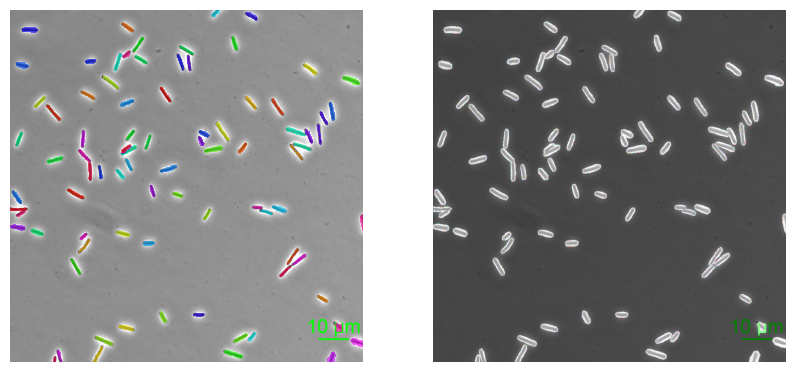

In [89]:
imgpath = "20240917_delta6_5.tif"
img = io.imread(imgpath)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
RunImage(img, imgpath)